# Analysing the pipeline results

Drought is an extremely damaging natural hazard. Operational drought monitoring often uses satellite measurements to determine drought severity and extent. In Kenya, the National Drought Monitoring Authority uses the **Vegetation Condition Index (VCI)** to determine whether or not to distribute emergency funds to counties ([Klitsch and Atsberger 2016](https://www.mdpi.com/2072-4292/8/4/267/htm))

Here we demonstrate the usefulness of our pipeline for predicting VCI from pre-existing hydrological and meteorological conditions (the weather!).

Our goal is to accurately predict *VCI* one month ahead. This would allow the Kenyan Drought Authority to proactively distribute funds ahead of damaging conditions. Machine learning has already been applied to this problem with impressive results ([Adede et al 2019](https://www.mdpi.com/2072-4292/11/9/1099/htm)). Can we do better?

### **NOTE 1**: 

We are using ready-to-use data that has already been through the pipeline.

Because of the time required to download, preprocess and train the models, the model here has already been trained and we are using the model predictions as saved in a zipfile in the `data` directory.

In order to run the pipeline end-to-end and reproduce the steps prior to this notebook, you will need to run the `run_demo.py` script in the `scripts/` directory.

#### The data:
Make sure you unzip the file `zip_data.zip`.

This will produce a folder `zip_data` which we will use as our base data directory. Remember, if you were to reproduce this analysis by running the pipeline from end-to-end then you would simply use the default data directory at `.data`.

Inside `data/zip_data` we have two directories. **`features`** and **`models`**.

**`features`** contains the data that has been through the `preprocessors` and the `engineers`. It only contains data for the `test` set in order to reduce the memory requirements. 

**`models`** contains data that has been predicted by the given model. It also contains a saved version.

Here we only have two models: **`ealstm`** and **`previous_month`** which is our baseline model.

### **NOTE 2**:
Here the data only includes the baseline `persistence` model and the state of the art Entity Aware Long-Short Term Memory (EALSTM) network. See the `notebooks/docs/Pipeline.ipynb` notebook for more information about the other models that we currently accomodate.

# Get the data!

### 1. download the zip file
Go to the [following link](http://www.mediafire.com/file/8txwi6y9l78uwvu/zip_data.zip/file) and download the `zip_data.zip` file

```
http://www.mediafire.com/file/8txwi6y9l78uwvu/zip_data.zip/file
```

### 1. unzip the file in `data/` directory

Move this folder into your `ml_drought/data` directory!

Unzip the file.

On Mac this is as simple as double clicking. 

If you wish to unzip using a command line interface running `bash`:

```bash
unzip zip_data.zip
```

# On to the analysis!

In [187]:
from pathlib import Path
import os
import warnings

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/Users/tommylees/github/ml_drought


In [2]:
# demonstrate how this analysis might be run for a different problem.
# how do we determine feature contributions?

In [199]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')

assert data_dir.exists(), f'Make sure ' \
    'that you have downloaded and unzipped the ' \
    'zip_data. This contains the processed data ' \
    'required to run the Notebook!'

## Model Evaluation Metrics

We have a few convenient analysis tools for evaluating model performance. 

Most of these functions are defined in `src/analysis/evaluation.py`. They are accesible through `src.analysis`.

Since the `data/` directory is managed by the pipeline it is easy to just specify the models and the metric of interest. Currently we have `rmse` and `r2` defined.

Here we extract a `pandas.DataFrame` object with the model performance metrics.

### How does our model perform over time?

In [189]:
from src.analysis import annual_scores

In [133]:
# load the monthly scores dictionary
monthly_scores = annual_scores(
    data_path=data_dir,
    models=['ealstm', 'previous_month'],
    metrics=['rmse', 'r2'],
    verbose=False,
    to_dataframe=False
)

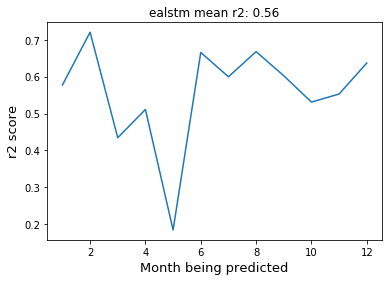

In [192]:
metric = 'r2'
for model in ['ealstm']:
    plt.clf()
    plt.plot(monthly_scores[metric]['month'], monthly_scores[metric][model])
    plt.xlabel('Month being predicted', size=13)
    plt.ylabel(f'{metric} score', size=13)
    plt.title(f'{model} mean {metric}: {np.mean(monthly_scores[metric][model]):.2f}')
    plt.show()

## Comparing predictions against the truth

We can either use the built in plotting functionality for comparing true and predicted data, or else we can load the data ourselves and use the flexibility of `xarray`. This is because all of the data is saved to `netCDF` files (`.nc`).

For month 1, ealstm error: 9.347525596618652


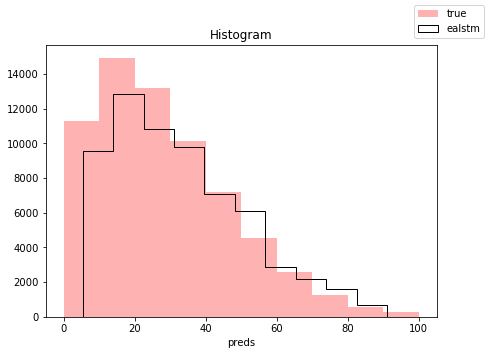

<Figure size 432x288 with 0 Axes>

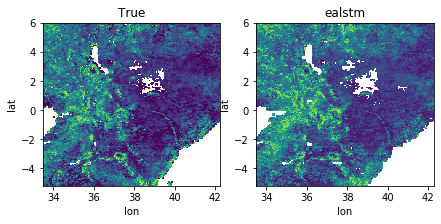

In [118]:
from src.analysis import plot_predictions

plot_predictions(
    pred_month=1, model='ealstm', 
    target_var='VCI', data_path=data_dir
)

## Comparison over Administrative Units

In order to make the results comparable with [Adede et al 2019](https://www.mdpi.com/2072-4292/11/9/1099/htm) and other existing work we provide grouping functionality. 

The first groupby objects aggregate the analysis by administrative regions. We also provide functionality to explore results by landcover.

We have used the `exporters` to [download shapefiles](https://data.humdata.org/dataset/47-counties-of-kenya). We then use the `preprocessors` to rasterize these shapefiles into pixel-level `netCDF` objects which can then be used by the `AdministrativeRegionAnalysis` to produce aggregate statistics per region.

**NOTE**: this code requires `geopandas` to be installed.

In [169]:
from src.analysis import AdministrativeRegionAnalysis
# from src.analysis import KenyaGroupbyRegion

In [165]:
analyzer = AdministrativeRegionAnalysis(data_dir=data_dir)
analyzer.analyze()

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['ealstm', 'previous_month']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries
* Analyzing for district_l2_kenya *

** Analyzing for ealstm-district_l2_kenya **
** Written ealstm csv to /Volumes/Lees_Extend/data/zip_data/analysis/region_analysis/ealstm/ealstm_district_l2_kenya.csv **

** Analyzing for previous_month-district_l2_kenya **
** Written previous_month csv to /Volumes/Lees_Extend/data/zip_data/analysis/region_analysis/previous_month/previous_month_district_l2_kenya.csv **
* Assigned all region dfs to `self.df` *

* Assigned Global Error Metrics to `self.global_mean_metrics` *
* Written csv to data/analysis/region_analysis/global_error_metrics_one_month_forecast_admin.csv *

* Assigned Regional Error Metrics to `self.regional_mean_metrics` *
* Written csv to data/analysis/region_analysis/regional_error_metrics_one_month_forecast_admin.csv *


In [185]:
# extract a GeoDataFrame that we can plot
gdf = analyzer.create_model_performance_by_region_geodataframe().gdf
gdf.head()

The RegionGeoPlotter requires `geopandas` to be installed.
The OCHA AdminBoundaries preprocessor requires the geopandas package
* Read shapefiles and stored in `RegionGeoPlotter.region_gdfs`
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


,model,admin_level_name,region_name,rmse,mae,r2,DISTNAME,geometry
0,ealstm,district_l2_kenya,NAIROBI,10.188009,8.357715,-0.023210,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
1,previous_month,district_l2_kenya,NAIROBI,11.051595,9.795107,-0.204027,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
2,ealstm,district_l2_kenya,SAMBURU,6.314932,5.495340,0.645855,SAMBURU,"POLYGON ((36.75165473150634 2.519848937106019,..."
3,previous_month,district_l2_kenya,SAMBURU,7.961759,5.947568,0.437061,SAMBURU,"POLYGON ((36.75165473150634 2.519848937106019,..."
4,ealstm,district_l2_kenya,TRANS MARA,8.154297,6.989141,0.254161,TRANS MARA,POLYGON ((35.15025473150634 -0.959251062893981...


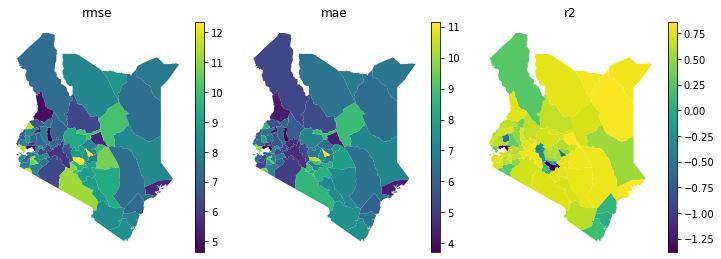

In [186]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 3, figsize=(12, 8))

for ax, metric in zip(axs, ['rmse', 'mae', 'r2']):
    # nicely format the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    ax.set_title(metric)
    ax.axis('off')
    gdf.loc[(gdf.model == 'ealstm')].plot(metric, ax=ax, cax=cax, legend=True)

## Model Interpretability

One of the key criticisms lobbied against machine learning based approaches is that the models are *black boxes*. During the Summer of Weather Code project, one of our key focuses was making the results interpretable. The key method for doing this in our pipeline is through using [SHAP values](https://github.com/slundberg/shap).

SHAP Values allow you to interrogate the relative importance of a feature for a prediction. They are measured in the units of the variable of interest and so a SHAP value of $-1$ means that feature $x$ negatively impacted VCI by a value of $-1$. 

All feature SHAP values sum to the prediction, so if you summed all SHAP values across all features you would recover the predicted VCI value.

For more information about SHAP values check the paper by [Lundberg et al 2018](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions).

Here we will demonstrate how SHAP values can be used in our context.

In [195]:
from src.analysis import plot_shap_values

analysis_dir = data_dir / 'models/one_month_forecast/ealstm/analysis/2018_3'
assert analysis_dir.exists()

In [200]:
# load the shap values
shap_historical = np.load(analysis_dir / 'shap_value_historical.npy')
with (analysis_dir / 'input_ModelArray.pkl').open('rb') as f:
    model_array = pickle.load(f)
with (data_dir / 'features/one_month_forecast/normalizing_dict.pkl').open('rb') as f:
    norm_dict = pickle.load(f)

In [242]:
variable_names = model_array.x_vars
input_historical = model_array.x.historical.numpy()
latlons = model_array.latlons
input_pred_months = model_array.x.pred_months.numpy()
shap_pred_months = shap_static = np.load(analysis_dir / 'shap_value_pred_months.npy')

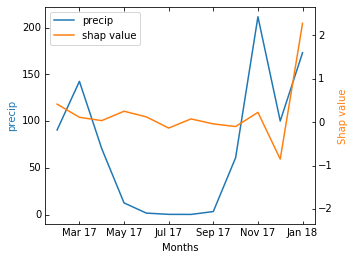

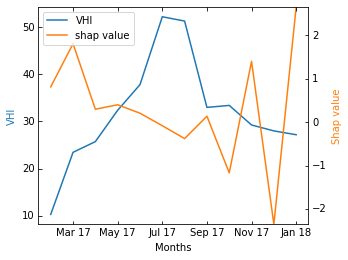

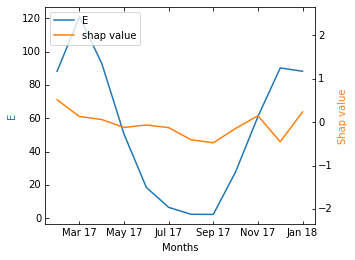

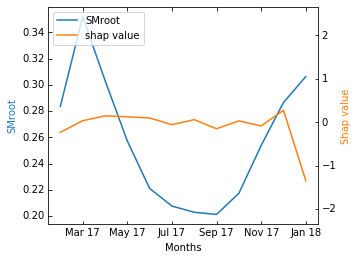

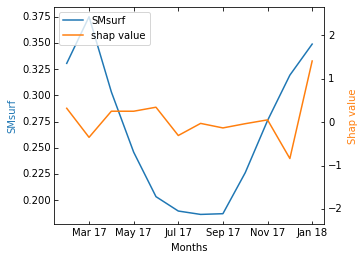

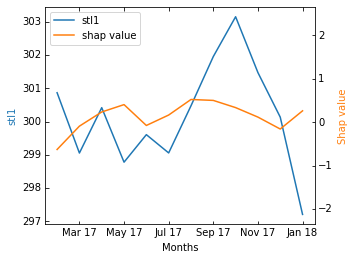

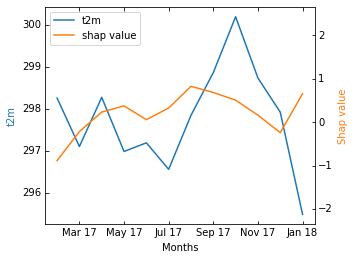

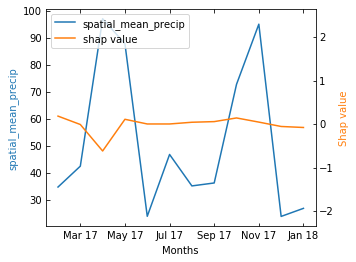

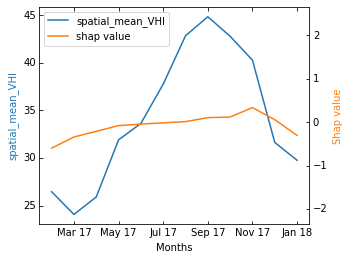

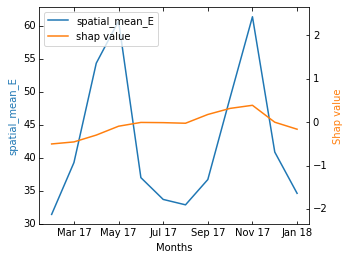

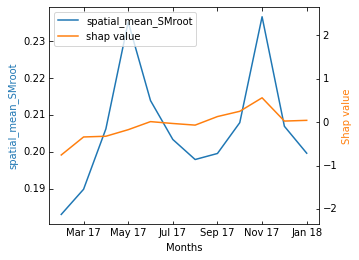

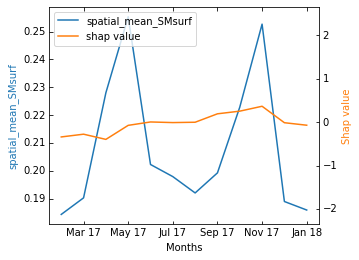

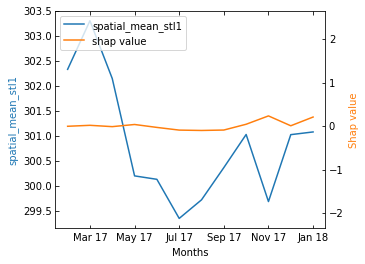

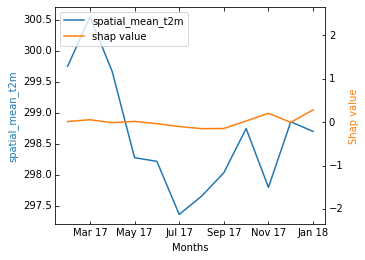

In [6]:
# only use the valid variables
ignore_vars = ['stl1', 'SMsurf']
valid_variables = np.array(variable_names)[~np.isin(variable_names, ignore_vars)]

for var in valid_variables:
    plt.clf()
    plot_shap_values(input_historical[0], shap_historical[0], variable_names, norm_dict, var, show=False,
                     pred_date=(np.where(input_pred_months[0] == 1)[0][0] + 1, 12))
    plt.savefig(analysis_dir/f'shap_plot_{var}.png', dpi=300, bbox_inches='tight')
    plt.show()